In [9]:
import open3d as o3d
import numpy as np
import os
import cv2
from math import atan, sqrt, degrees
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
def find_nearest_number(number_list, target_number):
    nearest_number = None
    min_difference = float('inf')  # Initialize with a large value

    for num in number_list:
        difference = abs(num - target_number)
        if difference < min_difference:
            min_difference = difference
            nearest_number = num

    return nearest_number

def depth_to_color(depth, colormap=cv2.COLORMAP_JET):
    normalized_depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
    color_map = cv2.applyColorMap(np.uint8(255 * normalized_depth), colormap)
    return color_map

def map_value(x, a, b, c, d):
    return c + (x - a) * (d - c) / (b - a)

In [3]:
def distort(x, y, k1, k2, p1, p2):

    rsq = x**2 + y**2

    x_dist = x*(1 + k1*rsq + k2*(rsq**2)) + 2*p1*x*y + p2*(rsq + 2*(x**2))
    y_dist = y*(1 + k1*rsq + k2*(rsq**2)) + p1*(rsq + 2*(y**2)) + p2*x*y

    return [x_dist, y_dist]

In [4]:
# Some user defined functions

 

# Quaternion multiplication
from evo.core.transformations import quaternion_multiply as quatmult
# Conversion between quat and rotm
from evo.core.transformations import quaternion_matrix as quat2rotm_
from evo.core.transformations import quaternion_from_matrix as rotm2quat
# Conversion between eul angles and rotm
from evo.core.transformations import euler_matrix as eul2rotm_
from evo.core.transformations import euler_from_matrix as rotm2eul_

 

def quat2rotm(q): return quat2rotm_(q)[0:3, 0:3]
def eul2rotm(e0, e1, e2): return eul2rotm_(e0, e1, e2, 'rzyx')[0:3, 0:3]
def rotm2eul(M): return rotm2eul_(M, 'rzyx')

 

# Extra definition for euler and quaternion
def eul2quat(e0, e1, e2): return rotm2quat(eul2rotm(e0, e1, e2))
def quat2eul(q): return rotm2eul(quat2rotm(q))

 

 

def pose2Tf(pose):
    q = pose[0, [6, 3, 4, 5]]
    t = np.reshape(pose[0, [0, 1, 2]], (3, 1))
    return Qt2Tf(q, t)

 

def Tf2Qt(T):
    q = rotm2quat(T[0:3, 0:3])
    t = T[0:3, 3:4]
    return q, t

 

def Qt2Tf(q, t):
    T = np.identity(4)
    T[0:3, 0:3] = quat2rotm(q)
    T[0:3, 3:4] = t
    return T

 

def Rt2Tf(R, t):
    T = np.identity(4)
    T[0:3, 0:3] = R
    T[0:3, 3:4] = t
    return T

 

def Tf2Rt(T):
    return (T[0:3, 0:3], T[0:3, 3:4])

 

def tfinv(T):
    R = T[0:3, 0:3].copy()
    t = T[0:3, 3:4].copy()
    R = R.transpose()
    t = np.dot(R, t)*(-1)
    return Rt2Tf(R, t)

 

def tfmult(T1, T2):

    R1 = T1[0:3, 0:3].copy()
    t1 = T1[0:3, 3:4].copy()

 

    R2 = T2[0:3, 0:3].copy()
    t2 = T2[0:3, 3:4].copy()

 

    R = np.dot(R1, R2)
    t = np.dot(R1, t2) + t1
    return Rt2Tf(R, t)

In [6]:
image_directory = r"/media/user/FantomHD/Aditya_Backup/home/Direc/MCD_DATA/NTU_DAY_01/ntu_day_01_d455b_data_defaced/image/__d455b__color__image_raw/"
point_cloud_file= r"/media/user/FantomHD/Aditya_Backup/home/Direc/MCD_DATA/NTU_DAY_01/ntu_day_01/inB/cloud_1_1644823131_490976810.pcd"

point_cloud_second=point_cloud_file[-24:-14]
point_cloud_nanosec=point_cloud_file[-13:-4]

closest_imgs=[]

for filename in os.listdir(image_directory):

    file_path = os.path.join(image_directory, filename)

    if file_path[-24:-14]==point_cloud_second:

        closest_imgs.append(int(file_path[-13:-4]))

closest_img=find_nearest_number(closest_imgs, int(point_cloud_nanosec))

image_path=image_directory + point_cloud_second + '_' + str(closest_img) + '.png'

print(image_path)


/media/user/FantomHD/Aditya_Backup/home/Direc/MCD_DATA/NTU_DAY_01/ntu_day_01_d455b_data_defaced/image/__d455b__color__image_raw/1644823131_503401728.png


In [7]:
pcd = o3d.io.read_point_cloud(point_cloud_file)

o3d.visualization.draw_geometries([pcd])

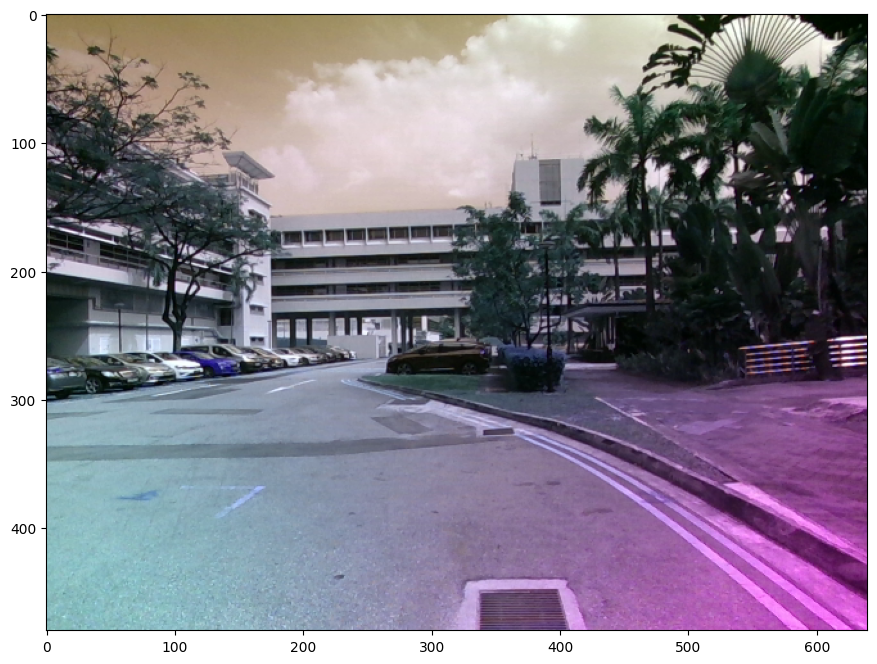

In [11]:
%matplotlib inline

image = cv2.imread(image_path)

plt.figure(figsize=(15,8))
plt.imshow(image)   

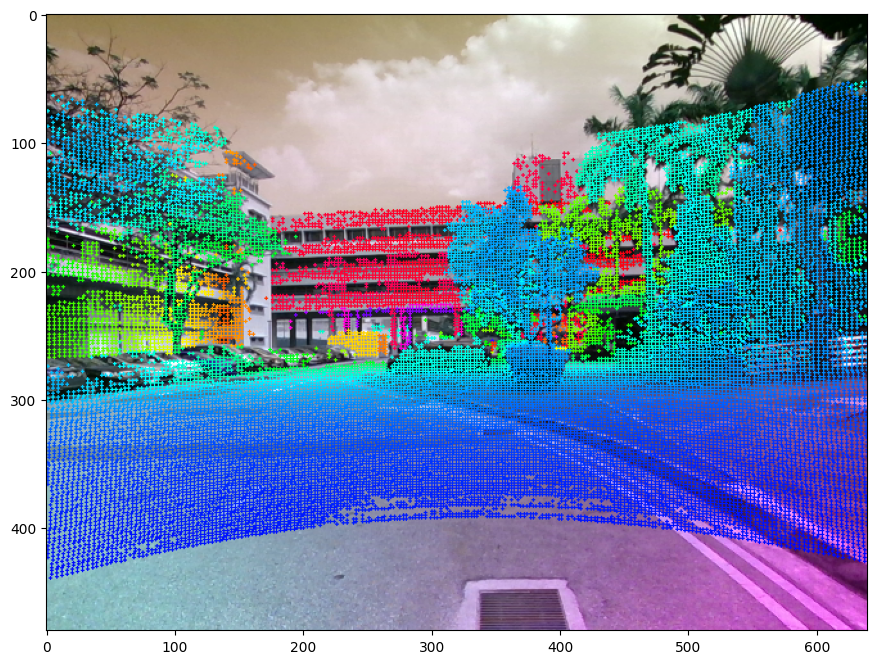

In [10]:
%matplotlib inline

T_B_C = np.array([[-0.01507104171318285, 0.005988709007546782, 0.9998684908857283, 0.05666674638032021],
                  [0.9998528146297833, -0.008108860850700655, 0.015119373419753048, 0.01100640924886362],
                  [0.00819833998937974, 0.9999491895792147, -0.005865618577067036, 0.11440342483060817],
                  [0.0, 0.0, 0.0, 1.0]])

intrinsics= [383.9298163754784, 382.9589851049001, 322.81111219908314, 250.9729552053214]

distortion_coeffs= [-0.04406471805202435, 0.04043629293187546, -1.2130737779239174e-06, 0.0018435172104962858]

d455b_fov=[90, 65] #in degrees

T_C_B = tfinv(T_B_C)

image = cv2.imread(image_path)

camera_points=[]
pixel_coords=[]
distorted_points=[]

for body in pcd.points:
    
    body = np.append(body, 1)

    camera_coord = np.dot(T_C_B, body)

    if (-45<degrees(atan(camera_coord[0]/sqrt(camera_coord[1]**2+camera_coord[2]**2)))<45) and (-32.5<degrees(atan(camera_coord[1]/sqrt(camera_coord[0]**2+camera_coord[2]**2)))<32.5) and camera_coord[2]>0:

        camera_points.append(camera_coord[:3])

        noramlized_points = (camera_coord[:3]/camera_coord[2])[:2]

        distorted_points = distort(noramlized_points[0], noramlized_points[1], distortion_coeffs[0], distortion_coeffs[1], distortion_coeffs[2], distortion_coeffs[3])

        pixel_coords.append([distorted_points[0]*intrinsics[0]+intrinsics[2], distorted_points[1]*intrinsics[1]+intrinsics[3], camera_coord[2]])


camera_points = np.array(camera_points)
pixel_coords = np.array(pixel_coords)

z_coordinates = [i[2] for i in pixel_coords]

# Normalize the z-coordinates to the range [0, 1]
normalized_z = (z_coordinates - np.min(z_coordinates)) / (np.max(z_coordinates) - np.min(z_coordinates))

# Replace the original z-coordinates with the normalized values
pixel_coords[:, 2] = [int(i*255) for i in normalized_z]


if image is None:
    print("Error: Could not read the image")
else:
    for coord in pixel_coords:
        x, y = int(coord[0]), int(coord[1])
        z = int(coord[2])
        bgr_color = cv2.cvtColor(np.array([[(z, 255, 255)]], dtype=np.uint8), cv2.COLOR_HSV2BGR)[0][0]
        bgr_color = (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2]))
        if x>0 and x<640 and y>0 and y<480:
            
            cv2.circle(image, (x, y), radius=1, color=bgr_color, thickness=-1)


    # Wait for a key press and close the window when a key is pressed
    cv2.imshow("Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
    plt.figure(figsize=(15,8))
    plt.imshow(image)   